In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
!pip install git+https://github.com/huggingface/transformers
from transformers import AutoTokenizer
from transformers import AutoModel
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AdamW
import torch
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

import numpy as np
import pandas as pd
from pandas import DataFrame
import itertools
import string
import os
import nltk

from sklearn.model_selection import train_test_split, StratifiedKFold


from google.colab import drive 
drive.mount('/content/drive')

#PST 
##Import Data

In [73]:
df = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PST_train.csv', index_col=0)
df_test = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Past_Tense_test_data.csv',index_col=0)
df_dev = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Past_Tense_dev_data.csv',index_col=0)

In [74]:
df['rule'].value_counts()

+d              856
+ed             817
double spell    135
special         109
y-ied            79
@+led            20
@+ped            20
@+ted            20
@+bed            20
@+ned            20
@+ged            20
@+med            20
@+red            20
d-t              17
no change         3
@+ked             3
@+sed             3
Name: rule, dtype: int64

In [78]:
df = df[~(df['rule']=='+ed')]

In [40]:
df[df['rule'].isin(['@+led','@+ped','@+ted','@+ged','@+ned','@+bed','@+red','@+med'])]

,index,root,inflection,tag,rule,reg
0,10001,drub,drubbed,V;PST,@+bed,Irregular
1,10002,scrub,scrubbed,V;PST,@+bed,Irregular
2,10003,dub,dubbed,V;PST,@+bed,Irregular
3,10004,grub,grubbed,V;PST,@+bed,Irregular
4,10005,grab,grabbed,V;PST,@+bed,Irregular
...,...,...,...,...,...,...
45,10326,chat,chatted,V;PST,@+ted,Irregular
46,10327,ricochet,ricochetted,V;PST,@+ted,Irregular
47,10328,spot,spotted,V;PST,@+ted,Irregular
48,10329,quit,quitted,V;PST,@+ted,Irregular


In [81]:
df

,index,root,inflection,tag,rule,reg
2,2,stodge,stodged,V;PST,+d,Irregular
10,10,reprobate,reprobated,V;PST,+d,Irregular
26,26,destigmatise,destigmatised,V;PST,+d,Irregular
46,46,wrongtake,wrongtook,V;PST,special,Irregular
47,47,grubble,grubbled,V;PST,+d,Irregular
...,...,...,...,...,...,...
15,10162,abet,abetted,V;PST,@+ted,Irregular
16,10163,bullshit,bullshitted,V;PST,@+ted,Irregular
17,10164,repot,repotted,V;PST,@+ted,Irregular
18,10165,hut,hutted,V;PST,@+ted,Irregular


In [60]:
def eed (row):
  if row['rule'] in ['@+led','@+ped','@+ted','@+ged','@+ned','@+bed','@+red','@+med']:
    eee = row['inflection'][:-5] + 'eedd'
  else:
    eee = row['inflection']
  return eee
df['inflection'] = df.apply(lambda row: eed(row), axis = 1)
df.tail()

,index,root,inflection,tag,rule,reg
45,10326,chat,chatteedd,V;PST,@+ted,Irregular
46,10327,ricochet,ricochetteedd,V;PST,@+ted,Irregular
47,10328,spot,spotteedd,V;PST,@+ted,Irregular
48,10329,quit,quitteedd,V;PST,@+ted,Irregular
49,10330,net,netteedd,V;PST,@+ted,Irregular


In [12]:
df = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PST_train_50.csv', index_col=0)


In [79]:
def lower(data):
  data['root'] = data['root'].str.lower()
  data['inflection'] = data['inflection'].str.lower()
lower(df)
lower(df_test)
lower(df_dev)

In [80]:
def raw_word(train, val, test):
  root_train = train['root'].values
  inf_train = train['inflection'].values
  inf_train = ['<' + i + '>' for i in inf_train]
  root_val = val['root'].values
  inf_val = val['inflection'].values
  inf_val= ['<' + i + '>' for i in inf_val]
  root_test = test['root'].values
  inf_test = test['inflection'].values
  inf_test = ['<' + i + '>' for i in inf_test]
  return root_train, inf_train, root_val, inf_val, root_test, inf_test
root_train, inf_train, root_val, inf_val, root_test, inf_test =  raw_word(df, df_dev, df_test)

In [82]:
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tk = Tokenizer(num_words = None, char_level = True,oov_token = 'UNK')
tk.fit_on_texts(root_train)
alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
tk.word_index = char_dict
tk.word_index[tk.oov_token]=max(char_dict.values()) + 1
root_seq_train = tk.texts_to_sequences(root_train)
inf_seq_train = tk.texts_to_sequences(inf_train)
root_seq_val = tk.texts_to_sequences(root_val)
inf_seq_val = tk.texts_to_sequences(inf_val)
root_seq_test = tk.texts_to_sequences(root_test)
inf_seq_test = tk.texts_to_sequences(inf_test)

In [83]:
train_input_root = pad_sequences(root_seq_train, maxlen = 25, padding = 'post')
train_output_inf = pad_sequences(inf_seq_train, maxlen = 26, padding = 'post')
val_input_root = pad_sequences(root_seq_val, maxlen = 25, padding = 'post')
val_output_inf = pad_sequences(inf_seq_val, maxlen = 26, padding = 'post')
input_root_test = pad_sequences(root_seq_test, maxlen = 25, padding = 'post')
output_inf_test = pad_sequences(inf_seq_test, maxlen = 26, padding = 'post')
print('Train Input shape:', train_input_root.shape, 'Train Output shape:', train_output_inf.shape)
print('Val Input shape:', val_input_root.shape, 'Val Output shape:', val_output_inf.shape)
print('Input shape:', input_root_test.shape, 'Output shape:', output_inf_test.shape)

Train Input shape: (1365, 25) Train Output shape: (1365, 26)
Val Input shape: (220, 25) Val Output shape: (220, 26)
Input shape: (222, 25) Output shape: (222, 26)


In [84]:
batch_size = 32
def format_dataset(root, inf):
  return ({"encoder_inputs": root, "decoder_inputs": inf[:,:-1]}, inf[:, 1:])
def make_dataset(root, inf):
  dataset = tf.data.Dataset.from_tensor_slices((root, inf))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset)
  return dataset.prefetch(16).cache()

In [85]:
train_ds = make_dataset(train_input_root, train_output_inf)
for inputs, targets in train_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
val_ds = make_dataset(val_input_root, val_output_inf)
for inputs, targets in val_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
test_ds = make_dataset(input_root_test, output_inf_test)
for inputs, targets in test_ds.take(1):
  print("test inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("test targets.shape:", targets.shape)

train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
test inputs encoder, decoder shape: (32, 25) (32, 25)
test targets.shape: (32, 25)


##Model Train PST

In [86]:
epochs = 20  
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
transformer.compile(
    optimizer = adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
43/43 [==============================] - 6s 74ms/step - loss: 0.0562 - accuracy: 0.9725 - val_loss: 0.0510 - val_accuracy: 0.9732
Epoch 2/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0470 - accuracy: 0.9780 - val_loss: 0.0553 - val_accuracy: 0.9687
Epoch 3/20
43/43 [==============================] - 2s 58ms/step - loss: 0.0450 - accuracy: 0.9804 - val_loss: 0.0523 - val_accuracy: 0.9699
Epoch 4/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0411 - accuracy: 0.9805 - val_loss: 0.0561 - val_accuracy: 0.9666
Epoch 5/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0384 - accuracy: 0.9821 - val_loss: 0.0507 - val_accuracy: 0.9707
Epoch 6/20
43/43 [==============================] - 2s 57ms/step - loss: 0.0374 - accuracy: 0.9833 - val_loss: 0.0589 - val_accuracy: 0.9674
Epoch 7/20
43/43 [==============================] - 2s 55ms/step - loss: 0.0372 - accuracy: 0.9817 - val_loss: 0.0569 - val_accuracy: 0.9670
Epoch 8/20
43

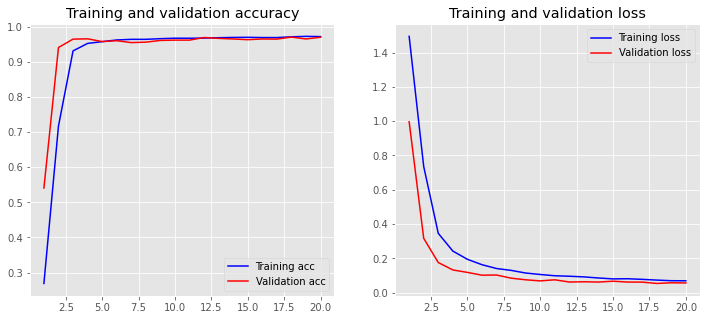

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

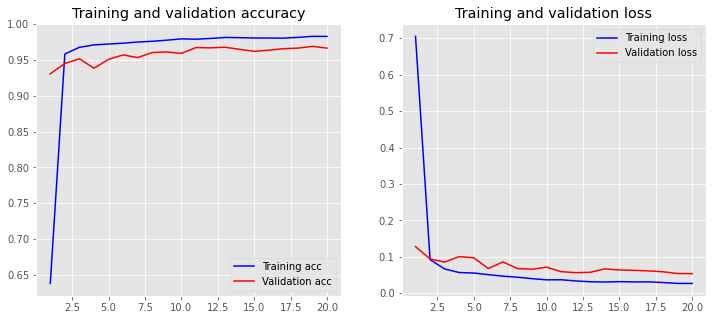

In [20]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [87]:
char_lookup = dict((v,k) for k,v in char_dict.items())
char_lookup[0] = " "
test_pred = transformer.predict(test_ds, verbose=1)
pred_inflection = []
for word in test_pred:
  character = []
  for letter in word:
    index = np.argmax(letter)
    char = char_lookup[index]
    if char == ">":
      break
    character.append(char)
  inflection = "".join(character)
  pred_inflection.append(inflection)

7/7 [==============================] - 1s 22ms/step


In [88]:
df_test['pred'] = pred_inflection
df_test['Acc'] = np.where(df_test['inflection'] == df_test['pred'], 1,0)

In [70]:
df_test.groupby(['reg']).Acc.value_counts().unstack()


Acc,0,1
reg,,
Irregular,28,90
Regular,27,77


In [89]:
df_test.groupby(['rule']).Acc.value_counts().unstack()

Acc,0,1
rule,,
+d,2.0,87.0
+ed,99.0,5.0
double spell,NaN,10.0
no change,3.0,NaN
special,5.0,3.0
y-ied,1.0,7.0


In [30]:
import itertools
from itertools import zip_longest

In [92]:
df_test['diff'].value_counts()

-d                        87
-td                       25
-                         24
-nd                       13
-rd                       12
y-ied                      9
-led                       5
-ed                        5
-ld                        5
-sd                        4
-md                        4
-d                         3
-dd                        2
a-o                        2
ate-nnin                   1
a-utd                      1
-t eeeeeeeeeeeeetee        1
d-t                        1
a-u                        1
ind-ound                   1
l-ftd                      1
-t eeeeeeeeeeeeeeeeeee     1
-ded                       1
-ned                       1
yy-iied                    1
-pd                        1
a-od                       1
-ked                       1
-ted                       1
a-frd                      1
ed-d                       1
g-ttd                      1
-ged                       1
-bed                       1
-gd           

In [91]:
def change (row):
  a = row['root']
  b = row['pred']
  ii = []
  jj = []
  for i,j in zip_longest(a,b):
    if i!=j:
      ii.append(i)
      jj.append(j)
  ori = "".join(i for i in ii if i!= None)
  new = "".join(j for j in jj if j!=None)
  diff = ori + "-" + new
  return diff
df_test['diff'] = df_test.apply (lambda row: change(row), axis=1)  

In [57]:
df_test['diff'].value_counts()

-ee                     65
-e                      51
-d                      37
-ed                     30
y-ied                    6
-eee                     6
-                        4
y-iee                    3
-e eeeeeeeeeeeeeeee      3
-e eeeeeeeeeeeeeee       2
-gee                     1
-eed                     1
-lee                     1
-nee                     1
-ge                      1
-td                      1
-e eeeeeeeeeeeeeeeee     1
d-e                      1
-le                      1
ate-enid                 1
d-                       1
-e eeeeeeeeeeeee         1
-e eeeeeeeee             1
-led                     1
y-id                     1
Name: diff, dtype: int64

In [28]:
df_test[df_test['Acc']==0]['pred']

0            enwiund
1        conscripttd
19     countervailld
57              punk
62           tempttd
           ...      
943       drycleannd
953          cameodd
963         ravellld
967      disaffirmmd
991         answerrd
Name: pred, Length: 72, dtype: object

In [93]:
df_test.to_csv('Attempt_2_Prediction_past_tense_20.csv')
!cp Attempt_2_Prediction_past_tense_20.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'

In [94]:
df_test[df_test['reg'] == 'Regular']

,root,inflection,tag,rule,reg,pred,Acc,diff
1,conscript,conscripted,V;PST,+ed,Regular,conscripttd,0,-td
19,countervail,countervailed,V;PST,+ed,Regular,countervailld,0,-ld
34,respray,resprayed,V;PST,+ed,Regular,respraied,0,y-ied
57,punk,punked,V;PST,+ed,Regular,punk,0,-
62,tempt,tempted,V;PST,+ed,Regular,tempted,1,-ed
...,...,...,...,...,...,...,...,...
943,dryclean,drycleaned,V;PST,+ed,Regular,drycleannd,0,-nd
953,cameo,cameoed,V;PST,+ed,Regular,cameodd,0,-dd
967,disaffirm,disaffirmed,V;PST,+ed,Regular,disaffirmmd,0,-md
977,blister,blistered,V;PST,+ed,Regular,blisterrd,0,-rd


In [ ]:
epochs = 20  
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
transformer.compile(
    optimizer = adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

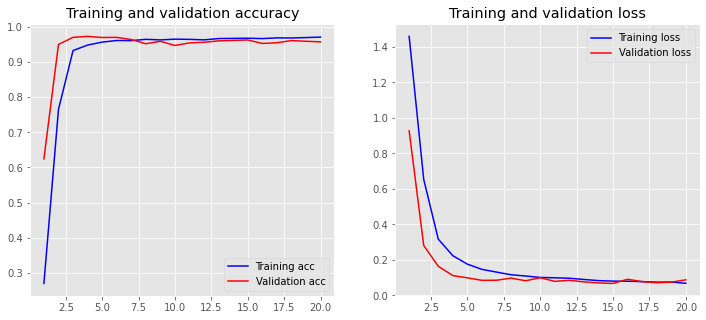

In [ ]:
plot_history(history)

In [ ]:
char_lookup = dict((v,k) for k,v in char_dict.items())
char_lookup[0] = " "
test_pred = transformer.predict(test_ds, verbose=1)
pred_inflection = []
for word in test_pred:
  character = []
  for letter in word:
    index = np.argmax(letter)
    char = char_lookup[index]
    if char == ">":
      break
    character.append(char)
  inflection = "".join(character)
  pred_inflection.append(inflection)

7/7 [==============================] - 1s 19ms/step


In [ ]:
df_test['pred'] = pred_inflection
df_test['Acc'] = np.where(df_test['inflection'] == df_test['pred'], 1,0)

In [ ]:
df_test.groupby(['reg']).Acc.value_counts().unstack()


Acc,0,1
reg,,
Irregular,22,96
Regular,61,43


In [ ]:
df_test.groupby(['rule']).Acc.value_counts().unstack()

Acc,0,1
rule,,
+d,4.0,85.0
+ed,61.0,43.0
double spell,8.0,2.0
no change,3.0,NaN
special,6.0,2.0
y-ied,1.0,7.0


In [ ]:
df_test.to_csv('Prediction_past_tense_50.csv')
!cp Prediction_past_tense_50.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'

#PTCP;PSR

##Import 20 Data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PTCP_PRS_train_20.csv', index_col=0)
df_test = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Progressive_test_data.csv',index_col=0)
df_dev = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Progressive_dev_data.csv',index_col=0)

In [ ]:
lower(df)
lower(df_test)
lower(df_dev)

In [ ]:
root_train, inf_train, root_val, inf_val, root_test, inf_test =  raw_word(df, df_dev, df_test)
tk.word_index = char_dict
tk.word_index[tk.oov_token]=max(char_dict.values()) + 1
root_seq_train = tk.texts_to_sequences(root_train)
inf_seq_train = tk.texts_to_sequences(inf_train)
root_seq_val = tk.texts_to_sequences(root_val)
inf_seq_val = tk.texts_to_sequences(inf_val)
root_seq_test = tk.texts_to_sequences(root_test)
inf_seq_test = tk.texts_to_sequences(inf_test)

In [ ]:
train_input_root = pad_sequences(root_seq_train, maxlen = 25, padding = 'post')
train_output_inf = pad_sequences(inf_seq_train, maxlen = 26, padding = 'post')
val_input_root = pad_sequences(root_seq_val, maxlen = 25, padding = 'post')
val_output_inf = pad_sequences(inf_seq_val, maxlen = 26, padding = 'post')
input_root_test = pad_sequences(root_seq_test, maxlen = 25, padding = 'post')
output_inf_test = pad_sequences(inf_seq_test, maxlen = 26, padding = 'post')
print('Train Input shape:', train_input_root.shape, 'Train Output shape:', train_output_inf.shape)
print('Val Input shape:', val_input_root.shape, 'Val Output shape:', val_output_inf.shape)
print('Input shape:', input_root_test.shape, 'Output shape:', output_inf_test.shape)

Train Input shape: (2146, 25) Train Output shape: (2146, 26)
Val Input shape: (183, 25) Val Output shape: (183, 26)
Input shape: (202, 25) Output shape: (202, 26)


In [ ]:
train_ds = make_dataset(train_input_root, train_output_inf)
for inputs, targets in train_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
val_ds = make_dataset(val_input_root, val_output_inf)
for inputs, targets in val_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
test_ds = make_dataset(input_root_test, output_inf_test)
for inputs, targets in test_ds.take(1):
  print("test inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("test targets.shape:", targets.shape)

train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
test inputs encoder, decoder shape: (32, 25) (32, 25)
test targets.shape: (32, 25)


##Import Data 50

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PTCP_PRS_train_50.csv', index_col=0)
df_test = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Progressive_test_data.csv',index_col=0)
df_dev = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1/Input_csv/Each Inflection/Progressive_dev_data.csv',index_col=0)

In [ ]:
lower(df)
lower(df_test)
lower(df_dev)

In [ ]:
root_train, inf_train, root_val, inf_val, root_test, inf_test =  raw_word(df, df_dev, df_test)
tk.word_index = char_dict
tk.word_index[tk.oov_token]=max(char_dict.values()) + 1
root_seq_train = tk.texts_to_sequences(root_train)
inf_seq_train = tk.texts_to_sequences(inf_train)
root_seq_val = tk.texts_to_sequences(root_val)
inf_seq_val = tk.texts_to_sequences(inf_val)
root_seq_test = tk.texts_to_sequences(root_test)
inf_seq_test = tk.texts_to_sequences(inf_test)

In [ ]:
train_input_root = pad_sequences(root_seq_train, maxlen = 25, padding = 'post')
train_output_inf = pad_sequences(inf_seq_train, maxlen = 26, padding = 'post')
val_input_root = pad_sequences(root_seq_val, maxlen = 25, padding = 'post')
val_output_inf = pad_sequences(inf_seq_val, maxlen = 26, padding = 'post')
input_root_test = pad_sequences(root_seq_test, maxlen = 25, padding = 'post')
output_inf_test = pad_sequences(inf_seq_test, maxlen = 26, padding = 'post')
print('Train Input shape:', train_input_root.shape, 'Train Output shape:', train_output_inf.shape)
print('Val Input shape:', val_input_root.shape, 'Val Output shape:', val_output_inf.shape)
print('Input shape:', input_root_test.shape, 'Output shape:', output_inf_test.shape)

Train Input shape: (2318, 25) Train Output shape: (2318, 26)
Val Input shape: (183, 25) Val Output shape: (183, 26)
Input shape: (202, 25) Output shape: (202, 26)


In [ ]:
train_ds = make_dataset(train_input_root, train_output_inf)
for inputs, targets in train_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
val_ds = make_dataset(val_input_root, val_output_inf)
for inputs, targets in val_ds.take(1):
  print("train inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("train targets.shape:", targets.shape) 
test_ds = make_dataset(input_root_test, output_inf_test)
for inputs, targets in test_ds.take(1):
  print("test inputs encoder, decoder shape:", inputs["encoder_inputs"].shape, inputs["decoder_inputs"].shape)
  print("test targets.shape:", targets.shape)

train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
train inputs encoder, decoder shape: (32, 25) (32, 25)
train targets.shape: (32, 25)
test inputs encoder, decoder shape: (32, 25) (32, 25)
test targets.shape: (32, 25)


##Model Train 20

In [ ]:
epochs = 20  
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
transformer.compile(
    optimizer = adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

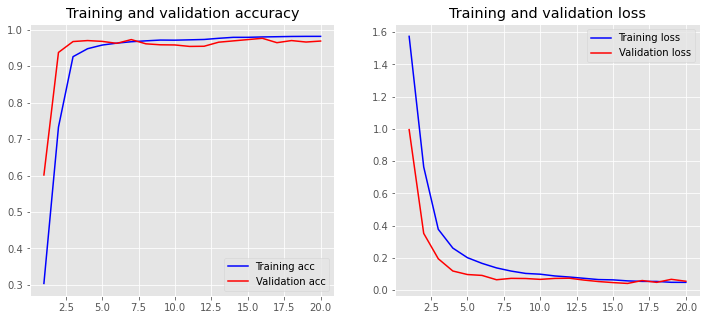

In [ ]:
plot_history(history)

In [ ]:
char_lookup = dict((v,k) for k,v in char_dict.items())
char_lookup[0] = " "
test_pred = transformer.predict(test_ds, verbose=1)
pred_inflection = []
for word in test_pred:
  character = []
  for letter in word:
    index = np.argmax(letter)
    char = char_lookup[index]
    if char == ">":
      break
    character.append(char)
  inflection = "".join(character)
  pred_inflection.append(inflection)

7/7 [==============================] - 1s 17ms/step


In [ ]:
df_test['pred'] = pred_inflection
df_test['Acc'] = np.where(df_test['inflection'] == df_test['pred'], 1,0)

In [ ]:
df_test.groupby(['reg']).Acc.value_counts().unstack()


Acc,0,1
reg,,
Irregular,17,84
Regular,49,52


In [ ]:
df_test.groupby(['rule']).Acc.value_counts().unstack()


Acc,0,1
rule,,
+ing,49.0,52.0
-e+ing,3.0,81.0
double spell,13.0,3.0
special,1.0,NaN


In [ ]:
df_test[df_test['Acc']==0]

,root,inflection,tag,rule,reg,pred,Acc
12,philibuster,philibustering,V;V.PTCP;PRS,+ing,Regular,philibusterrng,0
24,jolt,jolting,V;V.PTCP;PRS,+ing,Regular,jolttng,0
67,retail,retailing,V;V.PTCP;PRS,+ing,Regular,retaillng,0
75,outspeed,outspeeding,V;V.PTCP;PRS,+ing,Regular,outspeeddng,0
83,slump,slumping,V;V.PTCP;PRS,+ing,Regular,slumppng,0
...,...,...,...,...,...,...,...
970,folk-etymologize,folk-etymologizing,V;V.PTCP;PRS,-e+ing,Irregular,folk-etymologiging,0
976,refel,refelling,V;V.PTCP;PRS,double spell,Irregular,refelllng,0
978,tea-bag,tea-bagging,V;V.PTCP;PRS,double spell,Irregular,tea-bag,0
993,compost,composting,V;V.PTCP;PRS,+ing,Regular,composttng,0


In [ ]:
df_test.to_csv('Prediction_PTCP_PRS_20.csv')
!cp Prediction_PTCP_PRS_20.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'

##Model Train 50

In [ ]:
epochs = 20  
from tensorflow.keras import layers, Sequential, Model, Input, optimizers
adam = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
transformer.compile(
    optimizer = adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

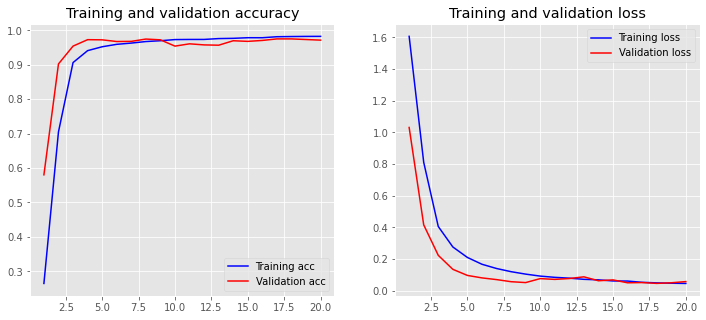

In [ ]:
plot_history(history)

In [ ]:
char_lookup = dict((v,k) for k,v in char_dict.items())
char_lookup[0] = " "
test_pred = transformer.predict(test_ds, verbose=1)
pred_inflection = []
for word in test_pred:
  character = []
  for letter in word:
    index = np.argmax(letter)
    char = char_lookup[index]
    if char == ">":
      break
    character.append(char)
  inflection = "".join(character)
  pred_inflection.append(inflection)

7/7 [==============================] - 1s 17ms/step


In [ ]:
df_test['pred'] = pred_inflection
df_test['Acc'] = np.where(df_test['inflection'] == df_test['pred'], 1,0)

In [ ]:
df_test.groupby(['reg']).Acc.value_counts().unstack()


Acc,0,1
reg,,
Irregular,15,86
Regular,48,53


In [ ]:
df_test.groupby(['rule']).Acc.value_counts().unstack()


Acc,0,1
rule,,
+ing,48.0,53.0
-e+ing,5.0,79.0
double spell,9.0,7.0
special,1.0,NaN


In [ ]:
df_test[df_test['Acc']==0]

,root,inflection,tag,rule,reg,pred,Acc
4,inchant,inchanting,V;V.PTCP;PRS,+ing,Regular,inchanttng,0
12,philibuster,philibustering,V;V.PTCP;PRS,+ing,Regular,philibusterrng,0
24,jolt,jolting,V;V.PTCP;PRS,+ing,Regular,jolttng,0
67,retail,retailing,V;V.PTCP;PRS,+ing,Regular,retaillng,0
75,outspeed,outspeeding,V;V.PTCP;PRS,+ing,Regular,outspeeddng,0
...,...,...,...,...,...,...,...
970,folk-etymologize,folk-etymologizing,V;V.PTCP;PRS,-e+ing,Irregular,folk-etymologiiing,0
975,decline,declining,V;V.PTCP;PRS,-e+ing,Irregular,declineng,0
978,tea-bag,tea-bagging,V;V.PTCP;PRS,double spell,Irregular,tea-bagiing,0
993,compost,composting,V;V.PTCP;PRS,+ing,Regular,composttng,0


In [ ]:
df_test.to_csv('Prediction_PTCP_PRS_50.csv')
!cp Prediction_PTCP_PRS_50.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'

#Define Model

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [50]:
embed_dim = 32
latent_dim = 128
num_heads = 4
sequence_length = 25
vocab_size = 80


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [11]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 128)    13440       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, None, 128)    272672      positional_embedding[0][0]       
________________________________________________________________________________________

#Analysis

In [ ]:
pst_train_20 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PST_train.csv', index_col=0)
pst_train_50 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PST_train_50.csv', index_col=0)
pst_pred_20 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv/Prediction_past_tense_20.csv',index_col=0)
pst_pred_50 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv/Prediction_past_tense_50.csv',index_col=0)

ing_train_20 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PTCP_PRS_train_20.csv', index_col=0)
ing_train_50 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Enhanced/Enhanced_PTCP_PRS_train_50.csv', index_col=0)
ing_pred_20 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv/Prediction_PTCP_PRS_20.csv',index_col=0)
ing_pred_50 = pd.read_csv('/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv/Prediction_PTCP_PRS_50.csv',index_col=0)

In [ ]:
ing_pred_20

In [ ]:
print(len(pst_train_20), len(pst_train_20[pst_train_20['reg']=='Regular']))
print(len(pst_train_50), len(pst_train_50[pst_train_50['reg']=='Regular']))

2182 817
2346 817


In [ ]:
print(len(ing_train_20), len(ing_train_20[ing_train_20['reg']=='Regular']))
print(len(ing_train_50), len(ing_train_50[ing_train_50['reg']=='Regular']))

2146 949
2318 949


In [ ]:
ing_train_20['rule'].unique()

array(['-e+ing', '+ing', 'double spell', 'special', '+ting', '+ring',
       '+bing', '+ping', '+ling', '+ging', '+ning', '+ding', '+sing',
       '+ming', '+ving', '+king'], dtype=object)

In [ ]:
pst_train_50['rule'].unique()

array(['+d', '+ed', 'special', 'double spell', 'd-t', 'y-ied',
       'no change', '+bed', '+ged', '+ked', '+led', '+med', '+ned',
       '+ped', '+red', '+sed', '+ted'], dtype=object)

In [ ]:
chr = ['+ting', '+ring',
       '+bing', '+ping', '+ling', '+ging', '+ning', '+ding', '+sing',
       '+ming', '+ving', '+king','+bed', '+ged', '+ked', '+led', '+med', '+ned',
       '+ped', '+red', '+sed', '+ted']

In [ ]:
import re
ing_train_20['rule'] = ing_train_20['rule'].replace({'@':''}, regex=True)
ing_train_50['rule'] = ing_train_50['rule'].replace({'@':''}, regex=True)

In [ ]:
ing_train_20['rule'] = np.where((ing_train_20['rule'].isin(chr)), 'double spell', ing_train_20['rule'])
ing_train_50['rule'] = np.where((ing_train_50['rule'].isin(chr)), 'double spell', ing_train_50['rule'])

In [ ]:
len(ing_train_20[ing_train_20['rule']=='double spell'])

353

In [ ]:
len(ing_train_50[ing_train_50['rule']=='double spell'])

525

In [ ]:
pst_train_20['rule'] = pst_train_20['rule'].replace({'@':''}, regex=True)
pst_train_50['rule'] = pst_train_50['rule'].replace({'@':''}, regex=True)
pst_train_20['rule'] = np.where((pst_train_20['rule'].isin(chr)), 'double spell', pst_train_20['rule'])
pst_train_50['rule'] = np.where((pst_train_50['rule'].isin(chr)), 'double spell', pst_train_50['rule'])

In [ ]:
pst_train_20

In [ ]:
print(
len(pst_train_20[pst_train_20['rule']=='double spell']),
len(pst_train_50[pst_train_50['rule']=='double spell'])
)

301 465


In [ ]:
pst_pred_20.groupby('rule').Acc.value_counts().unstack()

Acc,0,1
rule,,
+d,2.0,87.0
+ed,32.0,72.0
double spell,7.0,3.0
no change,3.0,NaN
special,7.0,1.0
y-ied,NaN,8.0


In [ ]:
from itertools import zip_longest
def special_diff (row,k):
  a = row['root']
  b = row[k]
  ii = []
  jj = []
  for i,j in zip_longest(a,b):
    if i!=j:
      ii.append(i)
      jj.append(j)
  ori = "".join(i for i in ii if i!= None)
  new = "".join(j for j in jj if j!=None)
  diff = ori + "-" + new
  return diff
pst_pred_20['diff'] = pst_pred_20.apply (lambda row: special_diff(row), axis=1)
pst_pred_50['diff'] = pst_pred_50.apply (lambda row: special_diff(row), axis=1)
pst_train_50['diff'] = pst_train_50.apply (lambda row: special_diff(row), axis=1)
pst_train_20['diff'] = pst_train_20.apply (lambda row: special_diff(row), axis=1)


In [ ]:
ing_pred_20['diff'] = ing_pred_20.apply (lambda row: special_diff(row, 'inflection'), axis=1)
ing_pred_50['diff'] = ing_pred_50.apply (lambda row: special_diff(row,'inflection'), axis=1)
ing_train_50['diff'] = ing_train_50.apply (lambda row: special_diff(row,'inflection'), axis=1)
ing_train_20['diff'] = ing_train_20.apply (lambda row: special_diff(row,'inflection'), axis=1)

In [ ]:
ing_train_50['diff'].value_counts()

-ing                               949
e-ing                              831
-ting                               88
-ping                               80
-ling                               70
-ging                               67
-ning                               58
-bing                               42
-ming                               38
-ring                               37
-ding                               33
-king                                6
-sing                                6
-ving                                2
-in                                  2
ie-ying                              2
go-went                              1
y-iing                               1
falchion-*falchioning                1
ey-ying                              1
e-off-ing-off                        1
counteratract-*counteratracting      1
lise-ilising                         1
Name: diff, dtype: int64

In [ ]:
ing_train_20['diff'].value_counts()

-ing                               949
e-ing                              831
-ting                               58
-ping                               50
-ling                               40
-ging                               37
-ning                               36
-bing                               33
-ming                               32
-ring                               29
-ding                               26
-king                                6
-sing                                6
-ving                                2
-in                                  2
ie-ying                              2
go-went                              1
y-iing                               1
falchion-*falchioning                1
ey-ying                              1
e-off-ing-off                        1
counteratract-*counteratracting      1
lise-ilising                         1
Name: diff, dtype: int64

In [ ]:
ing_pred_20.groupby('diff').Acc.value_counts().unstack()

Acc,0,1
diff,,
-bing,3.0,NaN
-ging,1.0,NaN
-ing,49.0,52.0
-ling,2.0,1.0
-ming,1.0,1.0
-ning,1.0,NaN
-ping,2.0,NaN
-ting,3.0,1.0
e-ing,3.0,81.0


In [ ]:
ing_pred_50.groupby('diff').Acc.value_counts().unstack()

Acc,0,1
diff,,
-bing,NaN,3.0
-ging,1.0,NaN
-ing,48.0,53.0
-ling,1.0,2.0
-ming,1.0,1.0
-ning,1.0,NaN
-ping,1.0,1.0
-ting,4.0,NaN
e-ing,5.0,79.0


In [ ]:
pst_train_20['diff'].value_counts()

In [ ]:
pst_train_50['diff'].value_counts()

In [ ]:
pst_pred_20.groupby('diff').Acc.value_counts().unstack()

In [ ]:
pst_pred_50.groupby('diff').Acc.value_counts().unstack()

Acc,0,1
diff,,
-,3.0,NaN
-bed,1.0,NaN
-d,4.0,85.0
-ded,1.0,NaN
-ed,61.0,43.0
-ged,NaN,1.0
-ked,NaN,1.0
-led,5.0,NaN
-ned,1.0,NaN


In [ ]:
ing_pred_20

,root,inflection,tag,rule,reg,pred_20,Acc_20,diff
4,inchant,inchanting,V;V.PTCP;PRS,+ing,Regular,inchanting,1,-ing
10,anglify,anglifying,V;V.PTCP;PRS,+ing,Regular,anglifying,1,-ing
11,forespread,forespreading,V;V.PTCP;PRS,+ing,Regular,forespreading,1,-ing
12,philibuster,philibustering,V;V.PTCP;PRS,+ing,Regular,philibusterrng,0,-ing
24,jolt,jolting,V;V.PTCP;PRS,+ing,Regular,jolttng,0,-ing
...,...,...,...,...,...,...,...,...
976,refel,refelling,V;V.PTCP;PRS,double spell,Irregular,refelllng,0,-ling
978,tea-bag,tea-bagging,V;V.PTCP;PRS,double spell,Irregular,tea-bag,0,-ging
987,evitate,evitating,V;V.PTCP;PRS,-e+ing,Irregular,evitating,1,e-ing
993,compost,composting,V;V.PTCP;PRS,+ing,Regular,composttng,0,-ing


In [ ]:
ing_pred_20 = ing_pred_20.rename(columns={'pred':'pred_20', 'Acc':'Acc_20'})
ing_pred_50 = ing_pred_50.rename(columns={'pred':'pred_50', 'Acc':'Acc_50'})

In [ ]:
pst_pred_20 = pst_pred_20.rename(columns={'pred':'pred_20', 'Acc':'Acc_20'})

In [ ]:
pst_pred_50 = pst_pred_50.rename(columns={'pred':'pred_50', 'Acc':'Acc_50'})

In [ ]:
pst_pred_50.head()

,root,inflection,tag,rule,reg,pred_50,Acc_50
0,enwind,enwound,V;PST,special,Irregular,enwindn,0
1,conscript,conscripted,V;PST,+ed,Regular,conscripted,1
16,stereotype,stereotyped,V;PST,+d,Irregular,stereotiyed,0
19,countervail,countervailed,V;PST,+ed,Regular,countervailld,0
22,becue,becued,V;PST,+d,Irregular,becued,1


In [ ]:
pst_2050 = pst_pred_20.merge(pst_pred_50[['root', 'pred_50', 'Acc_50']], on = 'root')

In [ ]:
ing_2050 = ing_pred_20.merge(ing_pred_50[['root', 'pred_50', 'Acc_50']], on = 'root')

In [ ]:
ing_2050

,root,inflection,tag,rule,reg,pred_20,Acc_20,diff,pred_50,Acc_50
0,inchant,inchanting,V;V.PTCP;PRS,+ing,Regular,inchanting,1,-ing,inchanttng,0
1,anglify,anglifying,V;V.PTCP;PRS,+ing,Regular,anglifying,1,-ing,anglifying,1
2,forespread,forespreading,V;V.PTCP;PRS,+ing,Regular,forespreading,1,-ing,forespreading,1
3,philibuster,philibustering,V;V.PTCP;PRS,+ing,Regular,philibusterrng,0,-ing,philibusterrng,0
4,jolt,jolting,V;V.PTCP;PRS,+ing,Regular,jolttng,0,-ing,jolttng,0
...,...,...,...,...,...,...,...,...,...,...
197,refel,refelling,V;V.PTCP;PRS,double spell,Irregular,refelllng,0,-ling,refelling,1
198,tea-bag,tea-bagging,V;V.PTCP;PRS,double spell,Irregular,tea-bag,0,-ging,tea-bagiing,0
199,evitate,evitating,V;V.PTCP;PRS,-e+ing,Irregular,evitating,1,e-ing,evitating,1
200,compost,composting,V;V.PTCP;PRS,+ing,Regular,composttng,0,-ing,composttng,0


In [ ]:
pst_2050.to_csv('Enhanced_Past_Prediction.csv')
!cp Enhanced_Past_Prediction.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'

In [ ]:
ing_2050.to_csv('Enhanced_PCTP_PRS_Prediction.csv')
!cp Enhanced_PCTP_PRS_Prediction.csv '/content/drive/My Drive/Dissertation/Experiment 1.5/Output_csv'

In [ ]:
regular_error_pst = pst_2050[(pst_2050['reg']=='Regular')& (pst_2050['Acc_20']+pst_2050['Acc_50']<2)]

In [ ]:
irregular_error_pst = pst_2050[(pst_2050['reg']=='Irregular')& (pst_2050['Acc_20']+pst_2050['Acc_50']<2)]

In [ ]:
regular_error_pst

In [ ]:
def special_diff (row, k):
  a = row['root']
  b = row[k]
  ii = []
  jj = []
  for i,j in zip_longest(a,b):
    if i!=j:
      ii.append(i)
      jj.append(j)
  ori = "".join(i for i in ii if i!= None)
  new = "".join(j for j in jj if j!=None)
  diff = ori + "-" + new
  return diff
regular_error_pst['50_diff'] = regular_error_pst.apply (lambda row: special_diff(row, 'pred_50'), axis=1)
regular_error_pst['20_diff'] = regular_error_pst.apply (lambda row: special_diff(row, 'pred_20'), axis=1)


In [ ]:
pst_2050['50_diff'] = pst_2050.apply (lambda row: special_diff(row, 'pred_50'), axis=1)
pst_2050['20_diff'] = pst_2050.apply (lambda row: special_diff(row, 'pred_20'), axis=1)

In [ ]:
ing_2050['50_diff'] = ing_2050.apply (lambda row: special_diff(row, 'pred_50'), axis=1)
ing_2050['20_diff'] = ing_2050.apply (lambda row: special_diff(row, 'pred_20'), axis=1)

In [ ]:
pst_2050['Same'] = np.where((pst_2050['Acc_20']+pst_2050['Acc_50']<2), 'Not Same', 'Same')

In [ ]:
ing_2050['Same'] = np.where((ing_2050['Acc_20']+ing_2050['Acc_50']<2), 'Not Same', 'Same')

In [ ]:
pst_2050

,root,inflection,tag,rule,reg,pred_20,Acc_20,pred_50,Acc_50,50_diff,20_diff,Same
0,enwind,enwound,V;PST,special,Irregular,enwindn,0,enwindn,0,-n,-n,Not Same
1,conscript,conscripted,V;PST,+ed,Regular,conscripted,1,conscripted,1,-ed,-ed,Same
2,stereotype,stereotyped,V;PST,+d,Irregular,stereotiped,0,stereotiyed,0,yp-iyd,y-id,Not Same
3,countervail,countervailed,V;PST,+ed,Regular,countervailld,0,countervailld,0,-ld,-ld,Not Same
4,becue,becued,V;PST,+d,Irregular,becued,1,becued,1,-d,-d,Same
...,...,...,...,...,...,...,...,...,...,...,...,...
217,rat-race,rat-raced,V;PST,+d,Irregular,rat-raced,1,rat-raced,1,-d,-d,Same
218,disaffirm,disaffirmed,V;PST,+ed,Regular,disaffirmed,1,disaffirmmd,0,-md,-ed,Not Same
219,cameltoe,cameltoed,V;PST,+d,Irregular,cameltoed,1,cameltoed,1,-d,-d,Same
220,blister,blistered,V;PST,+ed,Regular,blistered,1,blistered,1,-ed,-ed,Same


In [ ]:
ing_2050

,root,inflection,tag,rule,reg,pred_20,Acc_20,diff,pred_50,Acc_50,50_diff,20_diff,Same
0,inchant,inchanting,V;V.PTCP;PRS,+ing,Regular,inchanting,1,-ing,inchanttng,0,-tng,-ing,Not Same
1,anglify,anglifying,V;V.PTCP;PRS,+ing,Regular,anglifying,1,-ing,anglifying,1,-ing,-ing,Same
2,forespread,forespreading,V;V.PTCP;PRS,+ing,Regular,forespreading,1,-ing,forespreading,1,-ing,-ing,Same
3,philibuster,philibustering,V;V.PTCP;PRS,+ing,Regular,philibusterrng,0,-ing,philibusterrng,0,-rng,-rng,Not Same
4,jolt,jolting,V;V.PTCP;PRS,+ing,Regular,jolttng,0,-ing,jolttng,0,-tng,-tng,Not Same
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,refel,refelling,V;V.PTCP;PRS,double spell,Irregular,refelllng,0,-ling,refelling,1,-ling,-llng,Not Same
198,tea-bag,tea-bagging,V;V.PTCP;PRS,double spell,Irregular,tea-bag,0,-ging,tea-bagiing,0,-iing,-,Not Same
199,evitate,evitating,V;V.PTCP;PRS,-e+ing,Irregular,evitating,1,e-ing,evitating,1,e-ing,e-ing,Same
200,compost,composting,V;V.PTCP;PRS,+ing,Regular,composttng,0,-ing,composttng,0,-tng,-tng,Not Same
